# This notebook gives results to validate MFaM.

## Import libaries

In [1]:
import mfam
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'Arial',
        'size'   : 8.5}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.cm as cm
# from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

parent_dir = 'localdata/'
fig_path = r'C:/SURFdrive/PhD progress/PhDResearch/4_FCW/IV/Figures/'

## Global functions

In [ ]:
def lightc(colorname, alpha=1.0):
    color = mpl.colors.to_rgb(colorname)
    return (color[0], color[1], color[2], alpha)


def indicate_conflict(samples, parameters, ctype, alpha):
    conflicts = np.zeros(len(samples), dtype=bool)
    for roundv in parameters['round_v'].unique():
        threshold = parameters[(parameters['alpha']==alpha)&(parameters['ctype']==ctype)&(parameters['round_v']==roundv)]['threshold'].values[0]
        conflicts[samples['round_v']==roundv] = samples.loc[samples['round_v']==roundv, 's']<=threshold
    return conflicts


def confusion_matrix(indicated, conflict):
    true_positive = (indicated&conflict).sum()
    false_positive = (indicated&(~conflict)).sum()
    true_negative = ((~indicated)&(~conflict)).sum()
    false_negative = ((~indicated)&conflict).sum()
    sum_all = true_positive + false_positive + true_negative + false_negative
    return true_positive, false_positive, true_negative, false_negative, sum_all


def evaluate_detection(samples, parameters, conflict, dataset):
    results = []
    num_conflicts = samples[conflict].sum()

    for ttc_star in tqdm(np.arange(2.1,4,0.1), desc='ttc_star'):
        indicated_conflicts = (samples['s']<=(ttc_star*samples['v'])).values
        evaluation = confusion_matrix(indicated_conflicts, samples[conflict].values)
        tp, fp, tn, fn, sum_all = evaluation
        results.append([dataset, conflict, round(ttc_star,2), tp, fp, tn, fn, sum_all, num_conflicts])

    for alpha in tqdm(parameters['alpha'].unique(), desc='alpha'):
        indicated_conflicts = indicate_conflict(samples, parameters, conflict, alpha)
        evaluation = confusion_matrix(indicated_conflicts, samples[conflict].values)
        tp, fp, tn, fn, sum_all = evaluation
        results.append([dataset, conflict, round(alpha,2), tp, fp, tn, fn, sum_all, num_conflicts])

    results = pd.DataFrame(results, columns=['dataset','conflict','threshold','tp','fp','tn','fn','sum_all','num_conflicts'])
    return results

## Fig. 1 Illustration of the trade-off between missed and false alarms

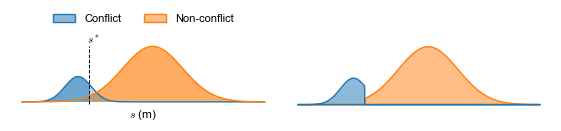

In [3]:
fig, axes = plt.subplots(1,2,figsize=(5.5,1.2),constrained_layout=True)
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

x = np.linspace(-2,11,1000)
nc = stats.norm.pdf(x, 5, 1.6)
c = stats.norm.pdf(x,1,0.7)/5

axes[0].plot(x, c, color='tab:blue', lw=1.)
axes[0].plot(x, nc, color='tab:orange', lw=1.)
axes[0].plot([1.6,1.6],[-0.01,0.25], color='k', lw=0.7, ls='--')

axes[0].fill_between(x, np.zeros_like(x), nc, color='tab:orange', ec='none', alpha=0.3)
nc[x<1.6] = 0
axes[0].fill_between(x, np.zeros_like(x), nc, color=lightc('tab:orange',0.5), ec='none')
axes[1].fill_between(x, np.zeros_like(x), nc, color=lightc('tab:orange',0.5), ec='tab:orange', label='Non-conflict')

axes[0].fill_between(x, np.zeros_like(x), c, color='tab:blue', ec='none', alpha=0.3)
c[x>=1.6] = 0
axes[0].fill_between(x, np.zeros_like(x), c, color=lightc('tab:blue',0.5), ec='none')
axes[1].fill_between(x, np.zeros_like(x), c, color=lightc('tab:blue',0.5), ec='tab:blue', label='Conflict')

axes[0].set_xlabel('$s$ (m)', labelpad=0)
axes[0].text(1.5, 0.255, '$s^*$', ha='left', va='bottom', fontsize=8)

handles, labels = axes[1].get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
axes[0].legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5,1.15), frameon=False, fontsize=8)

In [100]:
fig.savefig(fig_path+'sen_spe_explanation.pdf', bbox_inches='tight', dpi=600)

# Results

## Load data

In [3]:
samples_FreewayB = pd.read_hdf(parent_dir + 'samples/samples_FreewayB.h5', key='data')
parameters_FreewayB = pd.read_csv(parent_dir + 'space/parameters_FreewayB.csv')

results_FreewayB_I = evaluate_detection(samples_FreewayB, parameters_FreewayB, 'conflict_1', 'FreewayB_1')
results_FreewayB_II = evaluate_detection(samples_FreewayB, parameters_FreewayB, 'conflict_2', 'FreewayB_2')
results_FreewayB_III = evaluate_detection(samples_FreewayB, parameters_FreewayB, 'conflict_3', 'FreewayB_3')

results = pd.concat([results_FreewayB_I, results_FreewayB_II, results_FreewayB_III], axis=0)
results.to_csv(parent_dir + 'results.csv', index=False)

## Fig. 3 An example for missed and false alarm minimisation

In [5]:
roundvs = samples_FreewayB['round_v'].unique()
probs, smaxc = mfam.spacing_inference(samples_FreewayB, roundvs, 'FreewayB')
prob_s, prob_sc1, prob_sc2 = probs
smax_c1, smax_c2, c1, c2 = smaxc

FreewayB:   0%|          | 0/40 [00:00<?, ?it/s]

FreewayB: 100%|██████████| 40/40 [00:00<00:00, 83.63it/s]


In [6]:
ctype = 'conflict_2'
if ctype == 'conflict_1':
    prob_sc = prob_sc1
    smax_c = smax_c1
    c = c1
elif ctype == 'conflict_2':
    prob_sc = prob_sc2
    smax_c = smax_c2
    c = c2
    
idx = 34
# print(roundvs[idx])
prob_s_rv = prob_s[roundvs[idx]]
prob_sc_rv = prob_sc[roundvs[idx]]
smax = smax_c[idx]
c_rv = c[idx]
range_sc, pma, pfa = mfam.solve_threshold(prob_s_rv, prob_sc_rv, smax, c_rv)

3.8


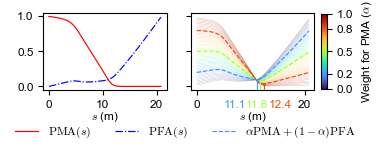

In [35]:
fig, axes = plt.subplots(1,2, figsize=(3.5,1.), sharey=True)

axes[0].plot(range_sc, pma, label='$\mathrm{PMA}(s)$', color='r', lw=0.85)
axes[0].plot(range_sc, pfa, label='$\mathrm{PFA}(s)$', color='b', lw=0.85, ls='-.')
axes[0].set_xlabel(r'$s$ (m)', labelpad=0.)

alpha_list = np.arange(0.02,1.,0.02)
color_list = cm.turbo(np.linspace(0,1,len(alpha_list)))
xticks = []
colors = []
for i in range(len(alpha_list)):
    alpha = round(alpha_list[i],2)
    color = color_list[i]
    axes[1].plot(range_sc, alpha*pma + (1-alpha)*pfa, color=color, lw=0.3, alpha=0.3)
    if alpha in [0.2,0.5,0.8]:
        weighted_sum = alpha*pma + (1-alpha)*pfa
        threshold = range_sc[np.argmin(weighted_sum)]
        axes[1].plot(range_sc, weighted_sum, label='$\\alpha\mathrm{PMA}+(1-\\alpha)\mathrm{PFA}$', color=color, lw=0.85, ls='--', zorder=300)
        axes[1].scatter(threshold, weighted_sum.min(), fc=color, ec=color, marker='o', s=2, zorder=400, lw=0.5)
        axes[1].plot([threshold,threshold],[-0.1,weighted_sum.min()], color=color, lw=0.85, ls='-', zorder=300)
        axes[1].set_xlabel(r'$s$ (m)', labelpad=0.)
        xticks.append(round(threshold,2))
        colors.append(color)
axes[1].set_ylim(-0.05,1.05)
axes[1].set_xticks([0,20])
axes[1].text(7,-0.33,str(xticks[0]), ha='center', va='bottom', fontsize=8.5, color=colors[0])
axes[1].text(11.2,-0.33,str(xticks[1]), ha='center', va='bottom', fontsize=8.5, color=colors[1])
axes[1].text(15.5,-0.33,str(xticks[2]), ha='center', va='bottom', fontsize=8.5, color=colors[2])

sm = plt.cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=0, vmax=1))
ax = fig.add_axes([0.92, 0.12, 0.015, 0.75])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_ticks([0,0.2,0.5,0.8,1])
cbar.set_label(r'Weight for PMA ($\alpha$)')

# legends
handle1, label1 = axes[0].get_legend_handles_labels()
handle2, label2 = axes[1].get_legend_handles_labels()
handles = handle1 + handle2[:1]
labels = label1 + label2[:1]
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.53, -0.5), ncol=3, frameon=False)

In [36]:
fig.savefig(fig_path + 'threshold_selection.pdf', bbox_inches='tight', dpi=600)

## Fig. 4-6 Type I/II/III conflict detection using TTC and MFaM

In [5]:
results = pd.read_csv(parent_dir + 'results.csv')

In [8]:
def scatter_validation(results, dataset):
    fig, axes = plt.subplots(2,3, figsize=(3.5,2.5), sharey='row', sharex='col', gridspec_kw={'width_ratios':[1,0.05,1]}, constrained_layout=True)
    for ax in [axes[0,1], axes[1,1]]:
        ax.axis('off')

    if dataset[-1]=='1':
        ctype = 'Type I: complete information and homogeneous conflicts'
    elif dataset[-1]=='2':
        ctype = 'Type II: complete information and heterogeneous conflicts'
    elif dataset[-1]=='3':
        ctype = 'Type III: incomplete information and heterogeneous conflicts'

    axes[0,1].set_title(ctype, fontsize=9, pad=15)
    axes[0,0].set_ylabel('Number')
    axes[1,0].set_ylabel('Percentage (%)')
    axes[0,0].set_title('TTC', fontsize=8.5, pad=3)
    axes[0,2].set_title('MFaM', fontsize=8.5, pad=3)
    axes[1,0].set_xlabel('Threshold (TTC*)', labelpad=2)
    axes[1,2].set_xlabel('Weight for missed alarms ($\\alpha$)', labelpad=0.5)

    
    for axid,tmin,tmax in zip([(0,0),(0,2)],[2,0],[4,1]):
        axes[axid].set_yticks([])
        axes[axid].set_xlim(tmin-(tmax-tmin)*0.03,tmax+(tmax-tmin)*0.03)
        result = results[(results['dataset']==dataset)&(results['threshold']>=tmin)&(results['threshold']<=tmax)]
        axes[axid].plot(result['threshold'], result['tp'], 'o-', lw=0.8, mew=0.8, markersize=3, color='k', mfc='none', label='Detected conflict moments')
        axes[axid].plot(result['threshold'], result['num_conflicts'], lw=0.8, color='k', ls='--', label='Total conflict moments')
        total_conflicts = result['num_conflicts'].iloc[0]
        axes[axid].text(tmin+(tmax-tmin)*0.03, total_conflicts, str(total_conflicts), fontsize=8, color='k', ha='left', va='bottom')
        min_conflicts = result['tp'].min()
        axes[axid].text(tmin+(tmax-tmin)*0.03, axes[axid].get_ylim()[0]-(axes[axid].get_ylim()[1]-axes[axid].get_ylim()[0])*0.03, 
                        str(min_conflicts), fontsize=8, color='k', ha='left', va='top')
    for axid in [(0,0),(0,2)]:
        ax = axes[axid]
        ax.set_ylim(ax.get_ylim()[0]-(ax.get_ylim()[1]-ax.get_ylim()[0])*0.08, ax.get_ylim()[1]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.06)
    
    for axid,tmin,tmax in zip([(1,0),(1,2)],[2,0],[4,1]):
        axes[axid].set_yticks([])
        axes[axid].set_xlim(tmin-(tmax-tmin)*0.08,tmax+(tmax-tmin)*0.08)

        result = results[(results['dataset']==dataset)&(results['threshold']>=tmin)&(results['threshold']<=tmax)]
        axes[axid].plot(result['threshold'], result['fn']/(result['tp']+result['fn'])*100, 's-', lw=0.8, mew=0.8, markersize=3, color=lightc('r',1), mfc='none', label='Missed alarms')
        val_max, val_min = round((result['fn']/(result['tp']+result['fn'])*100).max(),2), round((result['fn']/(result['tp']+result['fn'])*100).min(),2)
        pos_max, pos_min = val_max+(val_max-val_min)*0.05, val_min-(val_max-val_min)*0.05
        axes[axid].text(tmin+(tmax-tmin)*0.05, pos_max, val_max, fontsize=8, color=lightc('r',1), ha='center', va='bottom')
        axes[axid].text(tmax-(tmax-tmin)*0.05, pos_min, val_min, fontsize=8, color=lightc('r',1), ha='center', va='top')

        # result = result[(result['fn']/(result['tp']+result['fn']))<0.006].iloc[0:1]
        # # result = result[(result['fn']/(result['tp']+result['fn']))<0.694].iloc[0:1]
        # threshold = result['threshold'].values[0]
        # axes[axid].plot(result['threshold'], result['fn']/(result['tp']+result['fn'])*100, 's-', lw=0.8, mew=0.8, markersize=3, color='r', mfc='none', label='Missed alarms')
        # val = round((result['fn']/(result['tp']+result['fn'])*100).max(),2)
        # pos = val-(val_max-val_min)*0.1
        # axes[axid].text(threshold, pos, val, fontsize=8, color='r', ha='center', va='top')

        result = results[(results['dataset']==dataset)&(results['threshold']>=tmin)&(results['threshold']<=tmax)]
        axes[axid].plot(result['threshold'], result['fp']/(result['tp']+result['fp'])*100, 'D-', lw=0.8, mew=0.8, markersize=2.5, color=lightc('b',1), mfc='none', label='False alarms')
        val_max, val_min = round((result['fp']/(result['tp']+result['fp'])*100).max(),2), round((result['fp']/(result['tp']+result['fp'])*100).min(),2)
        pos_max, pos_min = val_max+(val_max-val_min)*0.05, val_min-(val_max-val_min)*0.05
        axes[axid].text(tmin+(tmax-tmin)*0.05, pos_min, val_min, fontsize=8, color=lightc('b',1), ha='center', va='top')
        axes[axid].text(tmax-(tmax-tmin)*0.05, pos_max, val_max, fontsize=8, color=lightc('b',1), ha='center', va='bottom')

        # result = result[(result['fn']/(result['tp']+result['fn']))<0.006].iloc[0:1]
        # # result = result[(result['fn']/(result['tp']+result['fn']))<0.694].iloc[0:1]
        # threshold = result['threshold'].values[0]
        # axes[axid].plot(result['threshold'], result['fp']/(result['tp']+result['fp'])*100, 'D-', lw=0.8, mew=0.8, markersize=2.5, color='b', mfc='none', label='False alarms')
        # val = round((result['fp']/(result['tp']+result['fp'])*100).max(),2)
        # pos = val+(val_max-val_min)*0.1
        # axes[axid].text(threshold, pos, val, fontsize=8, color='b', ha='center', va='bottom')
        

    for axid in [(1,0),(1,2)]:
        ax = axes[axid]
        ax.set_ylim(ax.get_ylim()[0]-(ax.get_ylim()[1]-ax.get_ylim()[0])*0.07, ax.get_ylim()[1]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.08)

    handle0, label0 = axes[0,0].get_legend_handles_labels()
    handle1, label1 = axes[1,0].get_legend_handles_labels()
    fig.legend([handle0[0], handle1[0], handle0[1], handle1[1]],
               [label0[0], label1[0], label0[1], label1[1]],
               loc='lower center', bbox_to_anchor=(0.5,-0.15), ncol=2, fontsize=8.5, frameon=False)
    
    return fig, axes

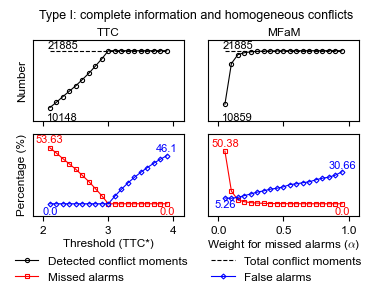

In [9]:
fig, axes = scatter_validation(results, 'FreewayB_1')

In [10]:
fig.savefig(fig_path + 'scatter_validation_FreewayB_1.pdf', bbox_inches='tight')

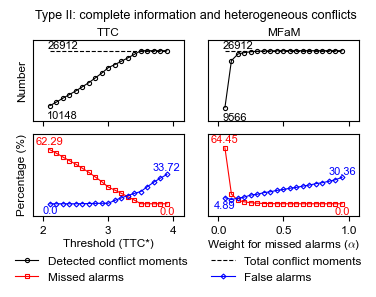

In [11]:
fig, axes = scatter_validation(results, 'FreewayB_2')

In [12]:
fig.savefig(fig_path+'scatter_validation_FreewayB_2.pdf', bbox_inches='tight')

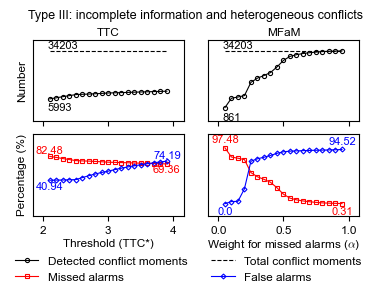

In [13]:
fig, axes = scatter_validation(results, 'FreewayB_3')

In [14]:
fig.savefig(fig_path+'scatter_validation_FreewayB_3.pdf', bbox_inches='tight')

## Fig. 7 Trade-off between miss rate and false rate in conflict detection

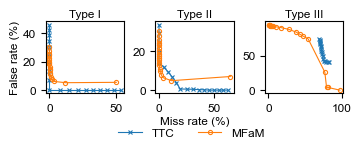

In [15]:
fig, axes = plt.subplots(1,3,figsize=(3.5,1.25), constrained_layout=True)

titles = ['Type I', 'Type II', 'Type III']
datasets = ['FreewayB_1', 'FreewayB_2', 'FreewayB_3']

for ax, title, dataset in zip(axes, titles, datasets):
    for tmin, tmax, color, marker in zip([2,0],[4,1],['tab:blue','tab:orange'], ['x','o']):
        result = results[(results['dataset']==dataset)&(results['threshold']>=tmin)&(results['threshold']<=tmax)]
        miss_rate = result['fn']/(result['tp']+result['fn'])*100
        false_rate = result['fp']/(result['tp']+result['fp'])*100
        ax.plot(miss_rate, false_rate, marker=marker, color=color, mfc='none', mew=0.8, markersize=3, lw=0.8)
    ax.set_title(title, fontsize=8.5, pad=3)

axes[0].set_ylabel('False rate (%)', labelpad=2)
axes[1].set_xlabel('Miss rate (%)', labelpad=2)

fig.legend([axes[0].lines[0], axes[0].lines[1]], ['TTC', 'MFaM'], loc='lower center', bbox_to_anchor=(0.53,-0.15), ncol=2, fontsize=8.5, frameon=False)

In [16]:
fig.savefig(fig_path+'scatter_validation.pdf', bbox_inches='tight')